In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config
from numba import cuda
import pickle


Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.51, 0.50), std=(0.35, 0.35), cvar(0.30)=(0.07, 0.07) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.65, 0.65), std=(0.10, 0.10), cvar(0.30)=(0.53, 0.54) (computed from 10000.0 saved samples)


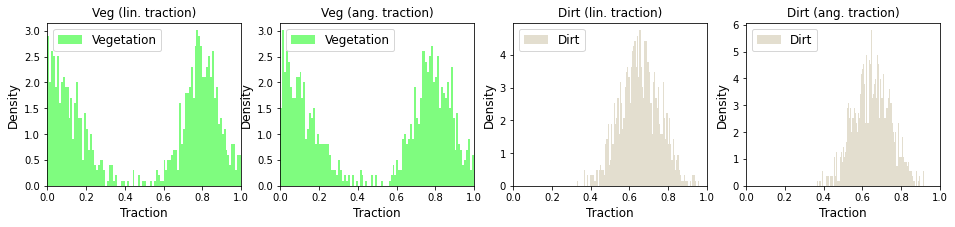

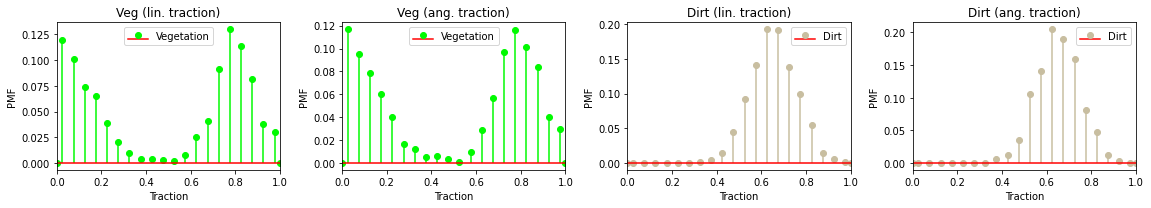

In [25]:
# What percentile of the speed distribution to compute conditional expectation?

pmf_bounds = [0, 1.0]
bush_weights = [0.6, 0.4]
bush_means= [0, 0.8]
bush_std = [0.15, 0.1]


dirt_weights = [1]
dirt_means = [0.65]
dirt_std = [0.1]
# dirt_weights = [1]
# dirt_means = [1]
# dirt_std = [0.001]
bush_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
bush_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
dirt_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)
dirt_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)

bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)
# print(np.sum(b_lin_pmf))
# print(np.sum(b_ang_pmf))
# print(np.sum(d_lin_pmf))
# print(np.sum(d_ang_pmf))



LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}
# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density(axes[0], bush_lin_gm, bush, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

### Methods to pre-generate the random problem setup (start, goal, envs with grass in middle)

10x10 cells, with the center 8x8 cells populated with grass

* Function to run a trial based on specification
* Use the same semantic env for N trials
* Use the same realization for different methods
* Log using panda dataframe and post process

In [26]:
# Trial function
def trial(mppi_planner, traction_grid, dt, max_speed, max_steps, num_pmf_bins, bin_values, bin_values_bounds, 
          xlimits, ylimits, res, mppi_params):
  # Loop
  xhist = np.zeros((max_steps+1, 3))*np.nan
  uhist = np.zeros((max_steps, 2))*np.nan
  xhist[0] = mppi_params['x0']
  goal_reached = False
  dist_to_goal = np.nan
  cum_obj = 0
  cum_dist_to_goal = 0
  for t in range(max_steps):
    # Solve
    useq = mppi_planner.solve()
    u_curr = useq[0]
    uhist[t] = u_curr

    # Simulate state forward using the sampled map
    lt, at = traction_grid.get(xhist[t,0], xhist[t,1])
    xhist[t+1, 0] = xhist[t, 0] + dt*lt*np.cos(xhist[t, 2])*u_curr[0]
    xhist[t+1, 1] = xhist[t, 1] + dt*lt*np.sin(xhist[t, 2])*u_curr[0]
    xhist[t+1, 2] = xhist[t, 2] + dt*at*u_curr[1]
    
    # Update MPPI state (x0, useq)
    mppi_planner.shift_and_update(xhist[t+1], useq, num_shifts=1)

    # Accumulate stage cost
    dist_to_goal = np.linalg.norm(xhist[t+1, :2] - mppi_params['xgoal']) - mppi_params['goal_tolerance']
    cum_obj += (dt+dist_to_goal)
    cum_dist_to_goal += dist_to_goal

    # Goal check
    if dist_to_goal <= 0:
      goal_reached = True
      break
  
  # Also log the dist to goal (minus the tolerance)
  if goal_reached:
    dist_to_goal = np.nan
  else:
    cum_obj += (1-goal_reached)*dist_to_goal/mppi_params['v_post_rollout']

  # Return trial_info
  trial_logger = dict(
    time_to_goal=(t+1)*dt if goal_reached else np.nan,
    success=goal_reached,
    dist_to_goal=dist_to_goal,
    cum_dist_to_goal=cum_dist_to_goal,
    avg_dist_to_goal=cum_dist_to_goal/(t+1),
    cum_obj=cum_obj,
    # xhist=xhist,
    # uhist=uhist
  )
  return trial_logger



def run_trials(orig_cfg, max_speed, max_steps, grid_shape, mud_margin, res, num_pmf_bins, bin_values, bin_values_bounds, default_mppi_params,
               grass_density_list, envs_per_density, trials_per_env, alpha_dyn_list, method_list):
  
  loggers = []

  cfg = copy.deepcopy(orig_cfg)

  # Pre-generate the semantic maps so they are the same for different alg settings
  lin_tdm = TDM_Numba(cfg)
  density_to_grid_configs = {gd: [] for gd in grass_density_list}
  # For each grass density
  for density_i, grass_density in enumerate(grass_density_list):
    # For each sampled semantic map, pre-generate realizations for evaluation (same more all methods)
    for sem_map_i in range(envs_per_density):
      
      # For whether edges are filled with dirt
      # for dirt_along_edge in [True, False]:
      for dirt_along_edge in [True]:
        rows, cols = grid_shape
        semantic_grid = np.zeros(grid_shape, dtype=np.int8)
        
        if dirt_along_edge:
          rand_num = np.random.rand(grid_shape[0]-2*mud_margin, grid_shape[1]-2*mud_margin)
          semantic_grid[mud_margin:-mud_margin, mud_margin:-mud_margin][rand_num<grass_density] = 1
        
        else:
          rand_num = np.random.rand(grid_shape[0], grid_shape[1])
          semantic_grid[rand_num<grass_density] = 1
          # Clear away cells around initial and end points
          semantic_grid[:mud_margin, :mud_margin] = 0
          semantic_grid[-mud_margin:, -mud_margin:] = 0

        xlimits = (0,semantic_grid.shape[1]*res)
        ylimits = (0,semantic_grid.shape[0]*res)
        
        # Pre-generate realizations of the map from groud truth distribution
        lin_tdm.reset()
        lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                      xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG) # no alpha here since we are just sampling traction
        traction_grid_samples = [lin_tdm.sample_grids_true_dist() for _ in range(trials_per_env)]
        
        density_to_grid_configs[grass_density].append({
          'semantic_grid': semantic_grid,
          'sem_map_i': sem_map_i,
          'realizations': traction_grid_samples,
          'dirt_along_edge': dirt_along_edge
        })


  # For each method (create MPPI object with proper method cfg)
  # For each grass density
  # For each sampled semantic map
  # For grass_along_edge=[True, False]
  # ------ Use all possible permutation of the following? -----
  # For each realized map
  # For each method alpha
  # For each semantic map (init TDM from semantic objects)
  # ------------------------------------------------------------
  for method_i, method in enumerate(method_list):
    cfg = copy.deepcopy(orig_cfg)

    cfg.use_tdm = False
    cfg.use_det_dynamics = False
    cfg.use_nom_dynamics_with_speed_map = False
    cfg.use_costmap = False
    if method == 'risk_dyn':
      cfg.use_det_dynamics = True
    elif method == 'nom_dyn_risk_cost':
      cfg.use_nom_dynamics_with_speed_map = True
    elif method == 'noisy_dyn':
      cfg.use_tdm = True
    elif method == "noisy_dyn_2x_env":
      cfg.use_tdm = True
      cfg.num_grid_samples *= 2
      assert cfg.num_grid_samples==orig_cfg.num_grid_samples*2
    elif method=='baseline':
      cfg.use_nom_dynamics_with_speed_map = True
    else:
      assert False
    
    # Create MPPI object for the method & initialize memory
    mppi_planner = MPPI_Numba(cfg)
    lin_tdm = TDM_Numba(cfg)
    ang_tdm = TDM_Numba(cfg)

    # For each grass density
    for density_i, grass_density in enumerate(grass_density_list):
      grid_cfgs = density_to_grid_configs[grass_density]
      for sg_dict in grid_cfgs:
        semantic_grid = sg_dict["semantic_grid"]
        sem_map_i = sg_dict["sem_map_i"]
        traction_grid_samples = sg_dict["realizations"]
        dirt_along_edge = sg_dict["dirt_along_edge"]

        # For each alpha
        t_alphas = time.time()
        for alpha_i, alpha_dyn in enumerate(alpha_dyn_list):
          print("method={}({}/{}), grass_density={} ({}/{}), grid ({}/{}), alpha_dyn={}({}/{}), with dirt edge = {}".format(
              method, method_i+1, len(method_list),
              grass_density, density_i+1, len(grass_density_list),
              sem_map_i+1, envs_per_density, 
              alpha_dyn, alpha_i+1, len(alpha_dyn_list),
              dirt_along_edge
            ))
          
          # If alpha changes and the map changes, the objects have to be reset and reinitialized
          lin_tdm.reset()
          ang_tdm.reset()
          mppi_planner.reset()
          lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                        xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG, det_dynamics_cvar_alpha=alpha_dyn)
          ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                              xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG, det_dynamics_cvar_alpha=alpha_dyn)

          trial_mppi_params = copy.deepcopy(default_mppi_params)
          # trial_mppi_params['cvar_alpha'] = alpha
          trial_mppi_params['alpha_dyn'] = alpha_dyn
          mppi_planner.setup(trial_mppi_params, lin_tdm, ang_tdm)

          if method=="baseline":
            # Set tractions all to 100
            hacked_padded_risk_traction_map = np.zeros(lin_tdm.risk_traction_map_d.shape, dtype=np.int8)
            hacked_padded_risk_traction_map[:,:,:] = np.int8(100)
            lin_tdm.risk_traction_map_d = cuda.to_device(hacked_padded_risk_traction_map)
            ang_tdm.risk_traction_map_d = cuda.to_device(hacked_padded_risk_traction_map)

          # For each realized map
          for map_sample_i, traction_grid in enumerate(traction_grid_samples):
            
            # Run trial
            trial_logger = trial(
              mppi_planner,
              traction_grid, 
              cfg.dt, 
              max_speed, 
              max_steps, 
              num_pmf_bins, 
              bin_values, 
              bin_values_bounds, 
              xlimits, 
              ylimits, 
              res, 
              trial_mppi_params)
            
            # Save other details
            trial_logger['dirt_along_edge'] = dirt_along_edge
            trial_logger['grass_density'] = grass_density
            trial_logger['grass_density_index'] = density_i
            trial_logger['sem_map_index'] = sem_map_i
            trial_logger['method'] = method
            trial_logger['alpha_dyn'] = alpha_dyn
            trial_logger['map_sample_index'] = map_sample_i

            loggers.append(trial_logger)
        t_elapsed = time.time()-t_alphas
        print("{:2f}s to do {} alphas and {} map realizations. ({:2f}s on average)".format(
          t_elapsed, len(alpha_dyn_list), len(traction_grid_samples), t_elapsed/(len(alpha_dyn_list)*len(traction_grid_samples))))

  return pd.DataFrame(loggers)


In [33]:
# ------------- Map configs ------------
grid_shape = (9, 9)
mud_margin = 1
res = 1.0
num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
bin_values = b_lin_values
bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))

# ------ Default fixed cfg for both MPPI and TDM (during object lifetime) ------
cfg_kwargs = dict(
  T = 10.0,
  dt = 0.1,
  num_grid_samples = 1024,
  num_control_rollouts = 1024,
  max_speed_padding = 5.0,
  num_vis_state_rollouts = 50,
  max_map_dim = (15, 15),
  seed = 1,
  use_tdm = True,
  use_det_dynamics = False,
  use_nom_dynamics_with_speed_map = False,
  use_costmap = False,
)
cfg = Config(**cfg_kwargs)

# ------------- Default problem params ------------
x0=np.array([mud_margin/2, mud_margin/2, np.pi/4])
xgoal= np.array([grid_shape[0]-mud_margin/2, grid_shape[0]-mud_margin/2])
max_speed = 3.0
max_steps = 150

default_mppi_params = dict(
    # Task specification
    dt=cfg.dt,
    x0=x0,
    xgoal=xgoal,
    # timesteps=cfg.num_steps,

    # For risk-aware min time planning
    goal_tolerance= mud_margin/2, 
    v_post_rollout=0.01,
    cvar_alpha=1.0, # use the mean if cvar_alpha=1.0
    alpha_dyn=1.0, # default is the mean of traction parameters

    # Hyper parameters
    lambda_weight=1.0,
    num_opt=1, # how many steps in each solve() function call

    # Control and sample specification
    # u_std=np.array([2.0, 2.0]),
    u_std=np.array([2.0, 3.0]),
    vrange=np.array([0, max_speed]), 
    wrange=np.array([-np.pi, np.pi]),
)

# # ------------- Variables to iterate ------------
# grass_density_list = [0.8, 0.6, 0.4, 0.2]
# envs_per_density = 20 # 40
# trials_per_env =  10
# # alpha_list = np.linspace(1.0, 0.2, 5).tolist()
# alpha_list = [1.0, 0.8, 0.6, 0.4, 0.2]
# method_list = ['noisy_dyn', 'risk_dyn','nom_dyn_risk_cost'] # 'baseline',

# ------------- Variables to iterate ------------
# grass_density_list = [0.8, 0.6]
grass_density_list = [0.8]
envs_per_density = 10 # 20 # 40
trials_per_env =  2 # 3 # 10
alpha_dyn_list = [0.4, 0.2]
method_list = ['noisy_dyn_2x_env', 'noisy_dyn', 'risk_dyn'] # 'baseline',


In [34]:
# filename = "mppi_benchmark/envs_{}_trials_{}_densities_{}_date_{}.pickle".format(
#                                                         envs_per_density,
#                                                         trials_per_env,
#                                                         len(grass_density_list),
#                                                         time.strftime("%Y%m%d-%H%M"))
filename = "mppi_benchmark/more_env_samples_envs_{}_trials_{}_densities_{}_date_{}.pickle".format(
                                                        envs_per_density,
                                                        trials_per_env,
                                                        len(grass_density_list),
                                                        time.strftime("%Y%m%d-%H%M"))

benchmark_start_t = time.time()
logger = run_trials(cfg, max_speed, max_steps, grid_shape, mud_margin, res, num_pmf_bins, bin_values, bin_values_bounds, default_mppi_params,
               grass_density_list, envs_per_density, trials_per_env, alpha_dyn_list, method_list)
benchmark_duration = time.time() - benchmark_start_t
print('Benchmark took {:.2f}s'.format(benchmark_duration))


TDM has initialized GPU memory after 0.06183314323425293 s
MPPI planner has initialized GPU memory after 0.016219615936279297 s
TDM has initialized GPU memory after 0.08094024658203125 s
TDM has initialized GPU memory after 0.07989048957824707 s
method=noisy_dyn_2x_env(1/3), grass_density=0.8 (1/1), grid (1/10), alpha=0.4(1/2), with dirt edge = True
method=noisy_dyn_2x_env(1/3), grass_density=0.8 (1/1), grid (1/10), alpha=0.2(2/2), with dirt edge = True
41.232441s to do 2 alphas and 2 map realizations. (10.308110s on average)
method=noisy_dyn_2x_env(1/3), grass_density=0.8 (1/1), grid (2/10), alpha=0.4(1/2), with dirt edge = True
method=noisy_dyn_2x_env(1/3), grass_density=0.8 (1/1), grid (2/10), alpha=0.2(2/2), with dirt edge = True
36.177832s to do 2 alphas and 2 map realizations. (9.044458s on average)
method=noisy_dyn_2x_env(1/3), grass_density=0.8 (1/1), grid (3/10), alpha=0.4(1/2), with dirt edge = True
method=noisy_dyn_2x_env(1/3), grass_density=0.8 (1/1), grid (3/10), alpha=0.2

In [35]:
# # ------------- Map configs ------------
# grid_shape = (9, 9)
# mud_margin = 1
# res = 1.0
# num_pmf_bins = len(d_ang_pmf) # Assume numbers of bins are the same for linear and angular components for now
# bin_values = b_lin_values
# bin_values_bounds = (np.min(b_lin_values), np.max(b_lin_values))





# Save the trials to
with open(filename, 'wb') as fh:
  pickle.dump(dict(
    # Main exp logger
    logger=logger,
    # Other configs
    cfg=cfg, 
    max_speed=max_speed, 
    max_steps=max_steps, 
    grid_shape=grid_shape, 
    mud_margin=mud_margin, 
    res=res, 
    num_pmf_bins=num_pmf_bins, 
    bin_values=bin_values, 
    bin_values_bounds=bin_values_bounds, 
    default_mppi_params=default_mppi_params,
    grass_density_list=grass_density_list, 
    envs_per_density=envs_per_density, 
    trials_per_env=trials_per_env, 
    alpha_dyn_list=alpha_dyn_list, 
    method_list=method_list,
    # Distributions
    pmf_bounds=pmf_bounds,
    bush_weights=bush_weights,
    bush_means=bush_means,
    bush_std=bush_std,
    dirt_weights=dirt_weights,
    dirt_means=dirt_means,
    dirt_std=dirt_std,
    ), file=fh
  )

print('Save to {}'.format(filename))

Save to mppi_benchmark/more_env_samples_envs_10_trials_2_densities_1_date_20220912-0140.pickle


,time_to_goal,success,dist_to_goal,cum_dist_to_goal,avg_dist_to_goal,cum_obj,dirt_along_edge,grass_density,grass_density_index,sem_map_index,method,alpha,map_sample_index
0,NaN,False,5.628301,1008.515845,6.723439,1586.345911,True,0.8,0,0,noisy_dyn_2x_env,0.4,0
1,12.3,True,NaN,649.593439,5.281247,661.893439,True,0.8,0,0,noisy_dyn_2x_env,0.4,1
2,NaN,False,0.876112,873.129580,5.820864,975.740812,True,0.8,0,0,noisy_dyn_2x_env,0.2,0
3,10.5,True,NaN,588.966649,5.609206,599.466649,True,0.8,0,0,noisy_dyn_2x_env,0.2,1
4,10.2,True,NaN,528.225223,5.178679,538.425223,True,0.8,0,1,noisy_dyn_2x_env,0.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,12.7,True,NaN,823.452096,6.483875,836.152096,True,0.8,0,8,risk_dyn,0.2,1
116,11.5,True,NaN,715.766191,6.224054,727.266191,True,0.8,0,9,risk_dyn,0.4,0
117,NaN,False,4.679167,885.025933,5.900173,1367.942640,True,0.8,0,9,risk_dyn,0.4,1
118,12.3,True,NaN,797.257886,6.481771,809.557886,True,0.8,0,9,risk_dyn,0.2,0


Dirt along edge?: True


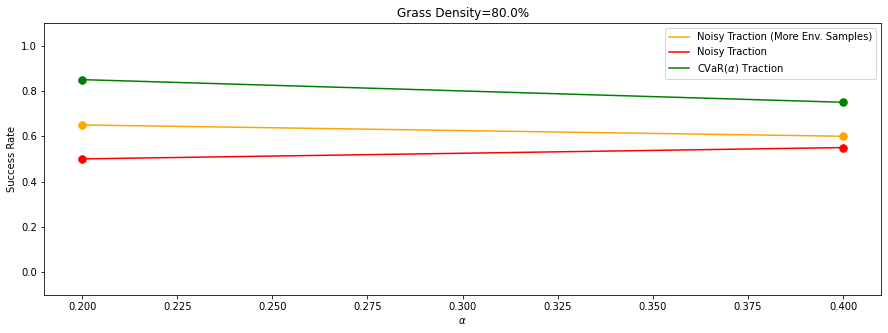

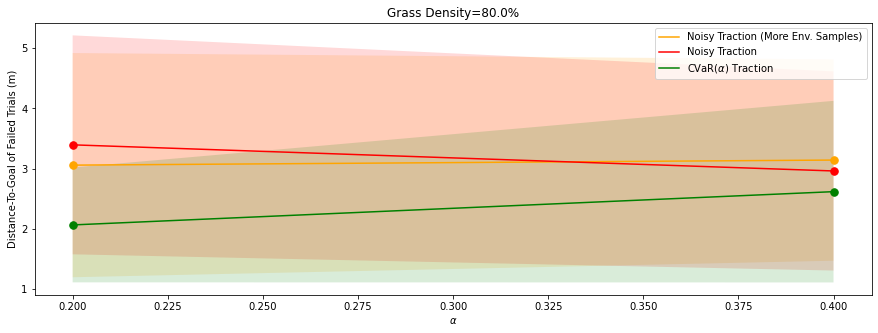

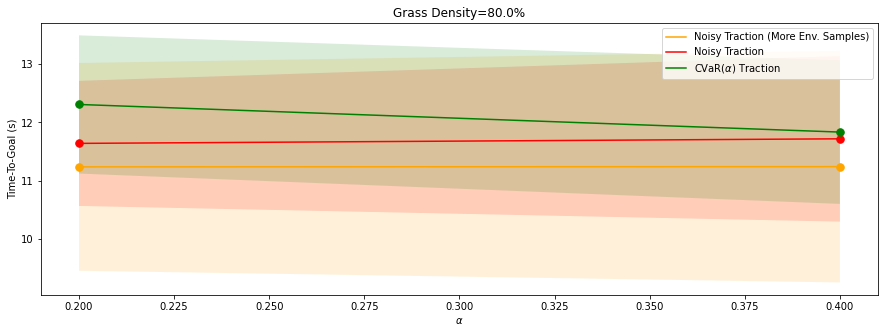

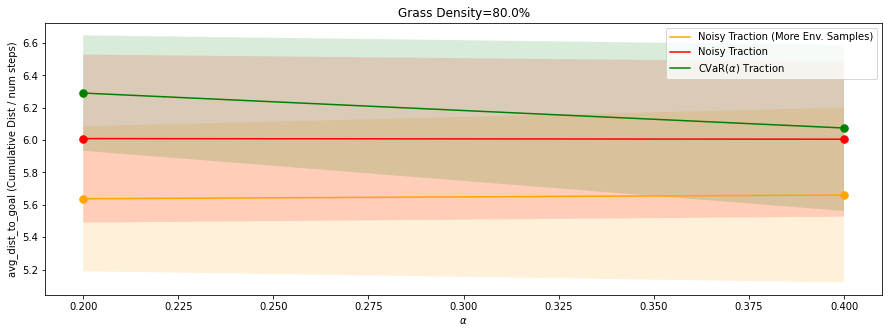

In [36]:
display(logger)

method2rgb = {
  'noisy_dyn': 'r',
  'noisy_dyn_2x_env': 'orange',
  'risk_dyn': 'g',
  'nom_dyn_risk_cost': 'b',
  'baseline': 'k',
}
method2label = {
  'noisy_dyn': 'Noisy Traction',
  'noisy_dyn_2x_env': "Noisy Traction (More Env. Samples)",
  'risk_dyn': r'CVaR($\alpha$) Traction',
  'nom_dyn_risk_cost': 'Risk-Adjusted Cost',
  'baseline': 'Baseline',
}
sorted_grass_density_list = sorted(grass_density_list)
sorted_alpha_list = sorted(alpha_dyn_list)
# Plot success rate vs. alpha for each method

for dirt_along_edge in [True]:

  print("Dirt along edge?: {}".format(dirt_along_edge))

  fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=(15, 5))
  for density_i, grass_density in enumerate(sorted_grass_density_list):
    if len(sorted_grass_density_list)==1:
      ax=axes
    else:
      ax = axes[density_i]
    for method in method_list:
      success_rate = []
      for alpha in sorted_alpha_list:
        sub_logger = logger[(logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha) & (logger['dirt_along_edge']==dirt_along_edge)]
        success_rate.append(sub_logger['success'].sum()/len(sub_logger))
      success_rate = np.asarray(success_rate)
      ax.plot(sorted_alpha_list, success_rate, '-', color=method2rgb[method], label=method2label[method])
      ax.plot(sorted_alpha_list, success_rate, '.', color=method2rgb[method], markersize=15)
    ax.legend()
    ax.set_ylim([-0.1,1.1])
    if density_i==0:
      ax.set_ylabel('Success Rate')
    ax.set_xlabel(r'$\alpha$')
    ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))
  plt.show()


  # Plot the dist-to-goal for the failed trials
  fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=(15, 5))
  for density_i, grass_density in enumerate(sorted_grass_density_list):
    if len(sorted_grass_density_list)==1:
      ax=axes
    else:
      ax = axes[density_i]
    for method in method_list:
      t2g = []
      t2g_std = []
      for alpha in sorted_alpha_list:
        sub_logger = logger[~logger['success'] & (logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha) & (logger['dirt_along_edge']==dirt_along_edge)]
        if len(sub_logger)>0:
          t2g.append(sub_logger['dist_to_goal'].sum()/len(sub_logger))
          t2g_std.append(sub_logger['dist_to_goal'].std())
        else:
          t2g.append(np.nan)
          t2g_std.append(np.nan)

          
      t2g = np.asarray(t2g)
      t2g_std = np.asarray(t2g_std)
      ax.plot(sorted_alpha_list, t2g, '-', color=method2rgb[method], label=method2label[method])
      ax.fill_between(sorted_alpha_list, t2g-t2g_std, t2g+t2g_std,
                alpha=0.15, edgecolor='none', facecolor=method2rgb[method])
      ax.plot(sorted_alpha_list, t2g, '.', color=method2rgb[method], markersize=15)
    ax.legend()
    if density_i==0:
      ax.set_ylabel('Distance-To-Goal of Failed Trials (m)')
    ax.set_xlabel(r'$\alpha$')
    ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))
  plt.show()


  # Plot time-to-goal for successful trials for each alpha
  fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=(15, 5))
  for density_i, grass_density in enumerate(sorted_grass_density_list):
    if len(sorted_grass_density_list)==1:
      ax=axes
    else:
      ax = axes[density_i]
    for method in method_list:
      t2g = []
      t2g_std = []
      for alpha in sorted_alpha_list:
        sub_logger = logger[logger['success'] & (logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha) & (logger['dirt_along_edge']==dirt_along_edge)]
        if len(sub_logger)>0:
          t2g.append(sub_logger['time_to_goal'].sum()/len(sub_logger))
          t2g_std.append(sub_logger['time_to_goal'].std())
        else:
          t2g.append(np.nan)
          t2g_std.append(np.nan)

          
      t2g = np.asarray(t2g)
      t2g_std = np.asarray(t2g_std)
      ax.plot(sorted_alpha_list, t2g, '-', color=method2rgb[method], label=method2label[method])
      ax.fill_between(sorted_alpha_list, t2g-t2g_std, t2g+t2g_std,
                alpha=0.15, edgecolor='none', facecolor=method2rgb[method])
      ax.plot(sorted_alpha_list, t2g, '.', color=method2rgb[method], markersize=15)
    ax.legend()
    if density_i==0:
      ax.set_ylabel('Time-To-Goal (s)')
    ax.set_xlabel(r'$\alpha$')
    ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))
  plt.show()

  # Plot time-to-goal for successful trials for each alpha
  fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=(15, 5))
  for density_i, grass_density in enumerate(sorted_grass_density_list):
    if len(sorted_grass_density_list)==1:
      ax=axes
    else:
      ax = axes[density_i]
    for method in method_list:
      t2g = []
      t2g_std = []
      for alpha in sorted_alpha_list:
        sub_logger = logger[logger['success'] & (logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha) & (logger['dirt_along_edge']==dirt_along_edge)]
        if len(sub_logger)>0:
          t2g.append(sub_logger['avg_dist_to_goal'].sum()/len(sub_logger))
          t2g_std.append(sub_logger['avg_dist_to_goal'].std())
        else:
          t2g.append(np.nan)
          t2g_std.append(np.nan)

          
      t2g = np.asarray(t2g)
      t2g_std = np.asarray(t2g_std)
      ax.plot(sorted_alpha_list, t2g, '-', color=method2rgb[method], label=method2label[method])
      ax.fill_between(sorted_alpha_list, t2g-t2g_std, t2g+t2g_std,
                alpha=0.15, edgecolor='none', facecolor=method2rgb[method])
      ax.plot(sorted_alpha_list, t2g, '.', color=method2rgb[method], markersize=15)
    ax.legend()
    if density_i==0:
      ax.set_ylabel('avg_dist_to_goal (Cumulative Dist / num steps)')
    ax.set_xlabel(r'$\alpha$')
    ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))
  plt.show()
  

In [37]:
# TODO: plot trade-off between time-to-goal and avg distance-to-goal
# TODO: third trade-off axis is terminal distance-to-goal (proxy to success rate). Less important for local planner